# 02_Preprocessing_and_Modeling

In this notebook we will build our preprocessing pipelines to handle:
1. Missing‐value imputation  
2. Categorical variable encoding  
3. Feature scaling 

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Reload cleaned data
df = pd.read_csv('../data/data0.csv', sep=';')
df.columns = df.columns.str.strip()

# Encode and split (from previous notebook)
le = LabelEncoder()
y = le.fit_transform(df['Target'])
X = df.drop(columns='Target')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 1. Define which columns go where

- **Numeric features** (floats)  
- **Categorical features** (integer‐coded categories)

In [48]:
categorical_cols = [
    'Marital status', 'Application mode', 'Application order',
    'Course', 'Daytime/evening attendance', 'Previous qualification',
    'Nacionality', "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation",
    'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder',
    'International'
]                                               # TOASK

all_features = X.columns.tolist()
numeric_cols = [c for c in all_features if c not in categorical_cols]

print("Categorical features: ", categorical_cols)
print("Numeric features: ", numeric_cols)

Categorical features:  ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
Numeric features:  ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Infl

In [49]:
ord_cols = [
    'Previous qualification',
    "Mother's qualification",
    "Father's qualification",
    'Application order'
]

nom_cols = [c for c in categorical_cols if c not in ord_cols]

print("Ordinal features: ", ord_cols)
print("Nominal features: ", nom_cols)

Ordinal features:  ['Previous qualification', "Mother's qualification", "Father's qualification", 'Application order']
Nominal features:  ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 'Nacionality', "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']


## 2. Build preprocessing pipelines

- **Numeric pipeline**: impute (median) → scale (StandardScaler)  
- **Categorical pipeline**: (optional) impute constant → encode (OneHotEncoder)

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Numeric pipeline: median‐impute → standard scale
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler',  StandardScaler())])

# Ordinal pipeline: constant‐impute → ordinal encode
ord_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=-1)), ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

# Nominal pipeline: constant‐impute → one‐hot encode
nom_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=-1)), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, numeric_cols),
    ('ord', ord_pipe,   ord_cols),
    ('nom', nom_pipe,   nom_cols)
], remainder='drop')

X_train_preprocessed = preprocessor.fit_transform(X_train)
print("Preprocessed X_train shape:", X_train_preprocessed.shape)

Preprocessed X_train shape: (3539, 170)


## 3.1 Full pipeline & hyperparameter tuning -> Random Forest

In [51]:
from sklearn.pipeline import Pipeline as Pl
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

selector = VarianceThreshold(threshold=0.01)

# Build the full pipeline
rf_pipe = Pl([('preproc', preprocessor), ('select',  selector), ('clf', RandomForestClassifier(random_state=42))])

rf_param_grid = {
    'select__threshold':    [0.0, 0.005, 0.01],  # no selection vs. two levels
    'clf__n_estimators':    [100, 200],          # number of trees
    'clf__max_depth':       [None, 10, 20],      # tree depth
    'clf__class_weight':    [None, 'balanced']   # handle class imbalance
}

rf_search = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True,    refit=True,
    error_score='raise'
)

rf_search.fit(X_train, y_train)

print("Best parameters:", rf_search.best_params_)
print("Best CV f1_macro:", rf_search.best_score_)

Best parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__n_estimators': 200, 'select__threshold': 0.01}
Best CV f1_macro: 0.7158287813795013


              precision    recall  f1-score   support

     Dropout       0.84      0.68      0.75       284
    Enrolled       0.44      0.60      0.51       159
    Graduate       0.84      0.84      0.84       442

    accuracy                           0.74       885
   macro avg       0.71      0.71      0.70       885
weighted avg       0.77      0.74      0.75       885



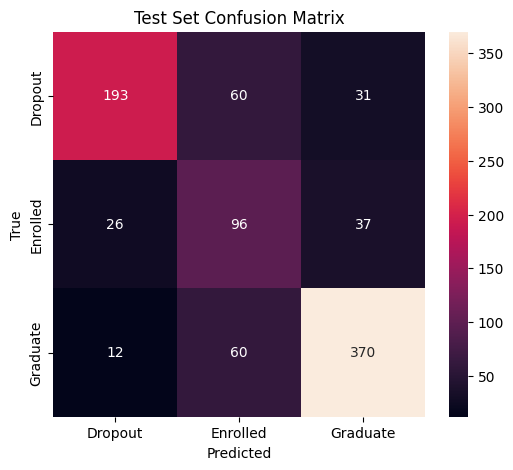

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieve best model
best_model = rf_search.best_estimator_

# Predict on test
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

## 3.2 Full pipeline & hyperparameter tuning -> Decision Tree

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline as Pl

dt_pipe = Pl([('preproc', preprocessor), ('select',  selector), ('clf', DecisionTreeClassifier(random_state=42))])

dt_param_grid = {
    'select__threshold':    [0.0, 0.005, 0.01],      # same selector choices
    'clf__max_depth':       [None, 5, 10, 20],       # tree depth
    'clf__min_samples_split': [2, 5, 10],            # controls overfitting
    'clf__class_weight':    [None, 'balanced']       # handle class imbalance
}

dt_search = GridSearchCV(
    dt_pipe,
    dt_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    error_score='raise'
)
dt_search.fit(X_train, y_train)

print("Decision Tree best params:", dt_search.best_params_)
print("Decision Tree best CV f1_macro:", dt_search.best_score_)

Decision Tree best params: {'clf__class_weight': 'balanced', 'clf__max_depth': 5, 'clf__min_samples_split': 2, 'select__threshold': 0.01}
Decision Tree best CV f1_macro: 0.6703179606484037


              precision    recall  f1-score   support

     Dropout       0.84      0.61      0.71       284
    Enrolled       0.35      0.65      0.46       159
    Graduate       0.83      0.73      0.78       442

    accuracy                           0.68       885
   macro avg       0.68      0.66      0.65       885
weighted avg       0.75      0.68      0.70       885



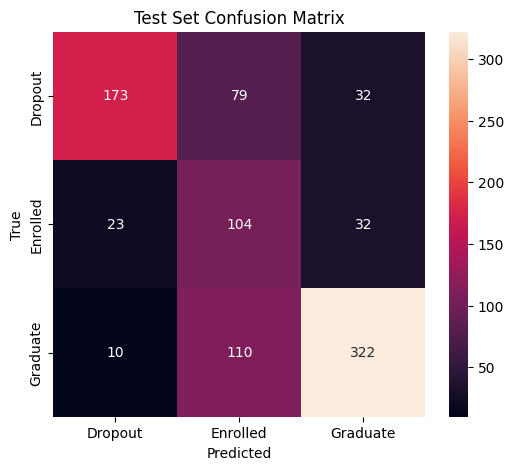

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieve best model
best_model = dt_search.best_estimator_

# Predict on test
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

## 3.3 Full pipeline & hyperparameter tuning -> K-Nearest Neighbors

In [55]:
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline        import Pipeline as Pl

knn_pipe = Pl([('preproc', preprocessor), ('select',  selector), ('clf', KNeighborsClassifier())
])

knn_param_grid = {
    'select__threshold': [0.0, 0.005, 0.01],  # selector choices
    'clf__n_neighbors': [3, 5, 7, 9],         # how many neighbors
    'clf__weights': ['uniform', 'distance'],  # weighting of votes
    'clf__p': [1, 2]                          # L1 (Manhattan) vs. L2 (Euclidean)
}

knn_search = GridSearchCV(
    knn_pipe,
    knn_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    error_score='raise'
)
knn_search.fit(X_train, y_train)

print("KNN best params:", knn_search.best_params_)
print("KNN best CV f1_macro:", knn_search.best_score_)

KNN best params: {'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'uniform', 'select__threshold': 0.01}
KNN best CV f1_macro: 0.5848015485681375


              precision    recall  f1-score   support

     Dropout       0.73      0.58      0.65       284
    Enrolled       0.41      0.36      0.39       159
    Graduate       0.74      0.86      0.80       442

    accuracy                           0.68       885
   macro avg       0.63      0.60      0.61       885
weighted avg       0.68      0.68      0.68       885



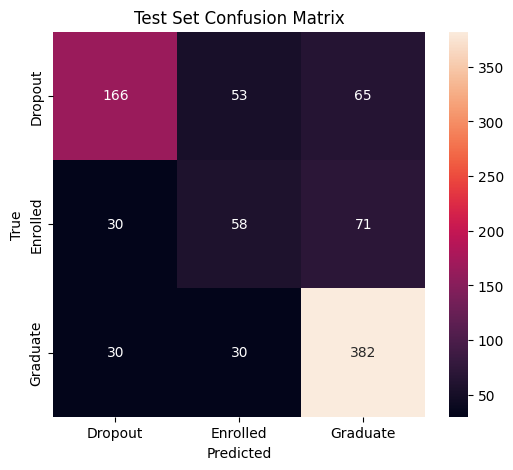

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieve best model
best_model = knn_search.best_estimator_

# Predict on test
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

## 7. Compare Tuned Models

We now have:
- **RF** tuned via `rf_search.best_params_` 
- **Decision Tree** tuned via `dt_search.best_params_`  
- **KNN** tuned via `knn_search.best_params_`  

Next, we’ll collect their best CV F1-macro into a small table, choose the best, and run the final test‐set evaluation on that model.

In [59]:
import pandas as pd

cv_comparison = pd.DataFrame({
    'RandomForest': [rf_search.best_score_],
    'DecisionTree': [dt_search.best_score_],
    'KNN':          [knn_search.best_score_]
}, index=['CV F1-macro']).T

cv_comparison

,CV F1-macro
RandomForest,0.715829
DecisionTree,0.670318
KNN,0.584802
